<a href="https://colab.research.google.com/github/Smartsie/Invest/blob/master/Invest_with_Currency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install investpy 
#==0.9.14

     |████████████████████████████████| 4.4MB 11.6MB/s 
     |████████████████████████████████| 245kB 32.6MB/s 
     |████████████████████████████████| 5.5MB 45.1MB/s 
     |████████████████████████████████| 512kB 21.6MB/s 
  Created wheel for investpy: filename=investpy-1.0-cp36-none-any.whl size=4465842 sha256=a287636fb8835f47bc971ec4aff4545d4b6f0a85e2812da0b7e6e6350a091ff2
  Stored in directory: /root/.cache/pip/wheels/ed/a0/ec/5866604d61abe747911c1ecafeea8ac27b5b17670e1191782a
Successfully built investpy
ERROR: convertdate 2.2.0 has requirement pytz<2020,>=2014.10, but you'll have pytz 2020.5 which is incompatible.
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
  Found existing installation: pytz 2018.9
    Uninstalling pytz-2018.9:
      Successfully uninstalled pytz-2018.9


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import investpy

In [3]:
Index='EUR/USD'

In [4]:
data = investpy.get_currency_cross_historical_data(currency_cross=Index,from_date='01/01/2000', to_date='24/01/2021')

In [5]:
# Calculate daily percentage variation
data['daily perc']=data.Close/data.Close.shift(1)
data=data.dropna(axis=0)

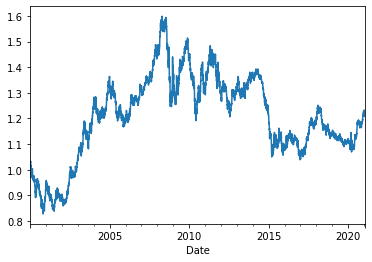

In [6]:
data['Close'].plot()

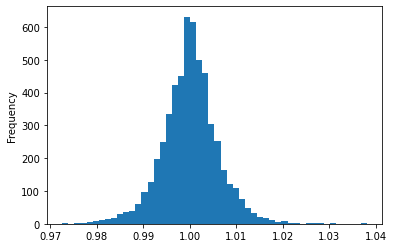

In [7]:
# plot distribution
data['daily perc'].plot(kind='hist',bins=50)

In [9]:
# Generate Dataset
lookback=100
horizon=5
X=[]
y=[]
for i in range(lookback,len(data)-horizon):
  data1=data['Close'].iloc[i-lookback:i].values
  data2=data['daily perc'].iloc[i-lookback:i].values
  target=data['Close'].iloc[i+horizon-1]
  X.append(np.append(data1,data2))
  y.append(target)
y=np.array(y).reshape(-1,1)

In [15]:
data.tail()

,Open,High,Low,Close,Currency,daily perc
Date,,,,,,
2021-01-18,1.2085,1.2091,1.2054,1.2076,USD,0.999834
2021-01-19,1.2078,1.2146,1.2074,1.2128,USD,1.004306
2021-01-20,1.2140,1.2158,1.2077,1.2114,USD,0.998846
2021-01-21,1.2114,1.2173,1.2110,1.2166,USD,1.004293
2021-01-22,1.2166,1.2190,1.2151,1.2171,USD,1.000411


In [16]:
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

In [17]:
scaler=MinMaxScaler()
scaler.fit(np.array(y))
X_=scaler.transform(X)
y_=scaler.transform(y)
X_train,X_test,y_train,y_test=train_test_split(X_,y_)

In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [160]:
model = keras.Sequential()
model.add(layers.Dense(20, activation="relu"))
model.add(layers.Dense(20, activation="relu"))
model.add(layers.Dense(1))
# compile the keras model
model.compile(loss='mse', optimizer='adam')

In [161]:
model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=1000, batch_size=100,verbose=0)

In [162]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 20)                4020      
_________________________________________________________________
dense_7 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 21        
Total params: 4,461
Trainable params: 4,461
Non-trainable params: 0
_________________________________________________________________


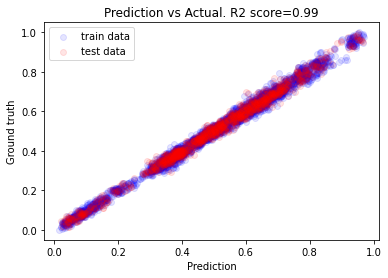

In [163]:
y_pred_train=model.predict(X_train)
y_pred_test=model.predict(X_test)
r2=r2_score(y_test, model.predict(X_test))
plt.scatter(y_pred_train,y_train,color='blue',alpha=0.1,label='train data')
plt.scatter(y_pred_test,y_test,color='red',alpha=0.1,label='test data')
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.title("Prediction vs Actual. R2 score=%0.2f"%r2)
plt.legend()
plt.show()


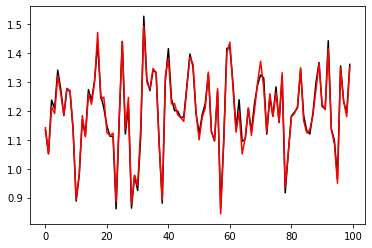

In [186]:
#plot_last_N days
n_plot=100
cours_actuel=scaler.inverse_transform(y_test[-n_plot:])
cours_predit=scaler.inverse_transform(y_pred_test[-n_plot:])
plt.plot(cours_actuel,color='black')
plt.plot(cours_predit,color='red')
plt.show()

In [205]:
# Predict in the last N days of known 
N=10
X_horiz=[]
for i in range(len(data)-horizon-N,len(data)-horizon):
  data1=data['Close'].iloc[i-lookback:i].values
  data2=data['daily perc'].iloc[i-lookback:i].values
  X_horiz.append(np.append(data1,data2))
X_to_predict=scaler.transform(X_horiz)
y_predicted=model.predict(X_to_predict)
y_predicted=scaler.inverse_transform(y_predicted)

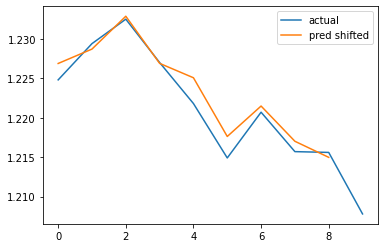

In [206]:
x=data['Close'][-N-horizon:-horizon].values
preds=pd.DataFrame()
preds['actual']=x
preds['pred']=y_predicted
preds['pred shifted']=preds['pred'].shift(-1)
preds[['actual','pred shifted']].plot()

In [193]:
# Predict in the next horizon days of known 
X_horiz=[]
for i in range(len(data)-horizon,len(data)):
  data1=data['Close'].iloc[i-lookback:i].values
  data2=data['daily perc'].iloc[i-lookback:i].values
  X_horiz.append(np.append(data1,data2))
X_to_predict=scaler.transform(X_horiz)
y_predicted=model.predict(X_to_predict)
y_predicted=scaler.inverse_transform(y_predicted)

In [204]:
e

[1, 2]

In [198]:
y_predicted.ravel()

array([1.2110833, 1.2090812, 1.2140936, 1.2121438, 1.217971 ],
      dtype=float32)

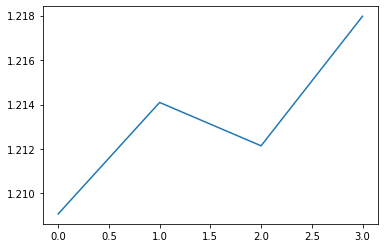

In [199]:
preds=pd.DataFrame()
preds['pred']=y_predicted.ravel()
preds['pred shifted']=preds['pred'].shift(-1)
preds['pred shifted'].plot()

In [207]:
print(preds)

   actual      pred  pred shifted
0  1.2248  1.223562      1.226882
1  1.2294  1.226882      1.228707
2  1.2325  1.228707      1.232872
3  1.2270  1.232872      1.226895
4  1.2218  1.226895      1.225070
5  1.2149  1.225070      1.217622
6  1.2207  1.217622      1.221483
7  1.2157  1.221483      1.217014
8  1.2156  1.217014      1.214975
9  1.2078  1.214975           NaN


In [209]:
data.tail(10)

,Open,High,Low,Close,Currency,daily perc
Date,,,,,,
2021-01-11,1.2217,1.2227,1.2132,1.2149,USD,0.994353
2021-01-12,1.2152,1.2211,1.2136,1.2207,USD,1.004774
2021-01-13,1.2208,1.2224,1.2140,1.2157,USD,0.995904
2021-01-14,1.2157,1.2179,1.2111,1.2156,USD,0.999918
2021-01-15,1.2155,1.2163,1.2074,1.2078,USD,0.993583
2021-01-18,1.2085,1.2091,1.2054,1.2076,USD,0.999834
2021-01-19,1.2078,1.2146,1.2074,1.2128,USD,1.004306
2021-01-20,1.2140,1.2158,1.2077,1.2114,USD,0.998846
2021-01-21,1.2114,1.2173,1.2110,1.2166,USD,1.004293


In [89]:
xx[1][-5:]

array([1.2294, 1.2325, 1.227 , 1.2218, 1.2149])

In [90]:
y_predicted[1]

array([1.207933], dtype=float32)

In [91]:
xx[2][-5:]

array([1.2325, 1.227 , 1.2218, 1.2149, 1.2207])

In [93]:
y_predicted[2]

array([1.2123753], dtype=float32)

In [70]:
model.predict(X_to_predict.reshape(1,-1))

ValueError: ignored

In [44]:
X_to_predict.reshape(-1,1)

array([[0.45936487],
       [0.4544394 ],
       [0.45742061],
       [0.4588464 ],
       [0.46299417],
       [0.46597537],
       [0.46299417],
       [0.45897602],
       [0.4632534 ],
       [0.46195723],
       [0.45314323],
       [0.44497732],
       [0.43888529],
       [0.44057032],
       [0.43512638],
       [0.43953338],
       [0.44964355],
       [0.44653273],
       [0.45029164],
       [0.44588464],
       [0.45469864],
       [0.44860661],
       [0.45197667],
       [0.45171743],
       [0.4602722 ],
       [0.4588464 ],
       [0.44990279],
       [0.45016202],
       [0.44497732],
       [0.44653273],
       [0.45275437],
       [0.45988334],
       [0.46506805],
       [0.45923526],
       [0.46480881],
       [0.45819831],
       [0.45651329],
       [0.44990279],
       [0.44082955],
       [0.43732988],
       [0.43642255],
       [0.44562541],
       [0.4470512 ],
       [0.45988334],
       [0.46649384],
       [0.4588464 ],
       [0.45897602],
       [0.454

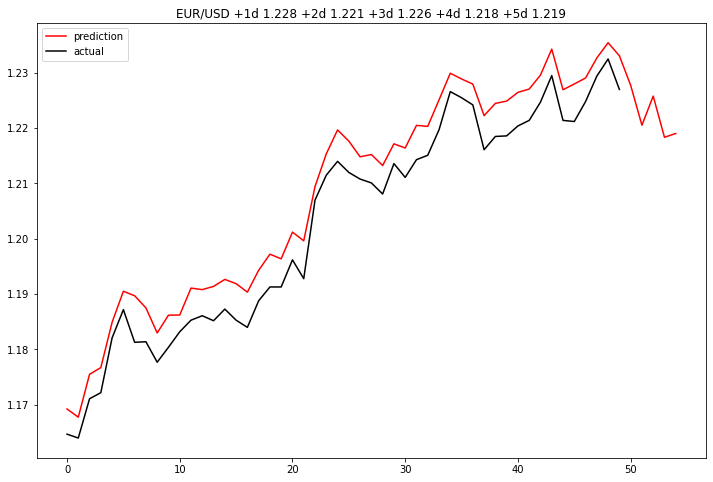

In [ ]:
plt.rcParams['figure.figsize'] = [12, 8]
N_days=50 # How many days to look back
y_pred_lookback=scaler.inverse_transform(model.predict(X_[-N_days:]))
plt.plot(np.append(y_pred_lookback,y_predicted),color='red',label='prediction')
plt.plot(y[-N_days-horizon:-horizon],color='black',label='actual')
plt.legend()
plt.title('EUR/USD +1d %0.3f'%y_predicted[0]+' +2d %0.3f'%y_predicted[1]+' +3d %0.3f'%y_predicted[2]+' +4d %0.3f'%y_predicted[3]+' +5d %0.3f'%y_predicted[4])
plt.show()


In [ ]:
y_predicted[1]

array([1.2205324], dtype=float32)

In [ ]:
len(np.append(y_pred_lookback,y_predicted))

200

In [ ]:
# We'll use this data to sample for the stock evolution

0


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



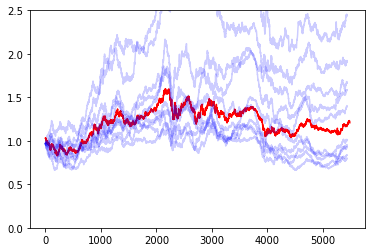

In [ ]:
plt.plot(data.Close.values,color='red')
plt.ylim((0,2.5))
N_start=50
df=data
for j in range (0,10):
  initial_stock=data['Close'].iloc[N_start]
  cours=np.array([initial_stock])
  df['T'+str(j)]=0
  print(j)
  for i in range(N_start,len(data)):
    # pick a random variation 
    perc=data['daily perc'][i-N_start:i].sample()
    cours=np.append(cours,cours[-1]*perc)
    df['T'+str(j)].iloc[i]=cours[-1]
  plt.plot(cours,color='blue',alpha=0.2)
plt.show() 


In [ ]:
# Calculate 95% percentile
df['lower']=0
df['median']=0
df['upper']=0
for j in range (0,len(df)):
  lower, median, upper=np.percentile(df.iloc[j][7:],[2.5,50,97.5])
  df['lower'].iloc[j]=lower
  df['median'].iloc[j]=median
  df['upper'].iloc[j]=upper

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



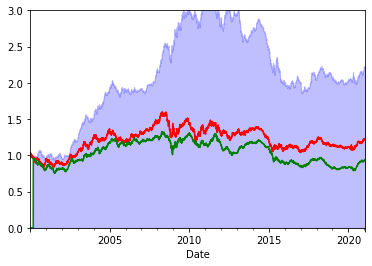

In [ ]:
df['Close'].plot(color='red')
plt.ylim((0,3))
df['median'].plot(color='green')
plt.fill_between(df.index,df['lower'],df['upper'],color='blue',alpha=0.25)
plt.show()

In [ ]:
# Extrapolate for n days using data from last N_start days
def extrapol(N_start=100,n=5):
  N_start=100
  n_traces=5000# how many traces we want
  df=data
  n=5 # amount of days to extrapolate
  X=pd.DataFrame()
  percent=df['daily perc'][-N_start:].values.tolist()
  for j in range(0,n_traces): # How many traces we generate
    cours=np.array([df.Close[-1]])
    for i in range(0,n):
      # pick a sample variation
      perc=np.random.choice(percent) #[i:])
      cours=np.append(cours,cours[-1]*perc)
      percent.append(perc)
    X['T'+str(j)]=cours 
    # Calculate 95% percentile
  X['lower']=0
  X['median']=0
  X['upper']=0
  for j in range (0,len(X)):
    lower, median, upper=np.percentile(X.iloc[j][0:],[5,50,97.5])
    X['lower'].iloc[j]=lower
    X['median'].iloc[j]=median
    X['upper'].iloc[j]=upper
  # Plot the extrapolation
  #plt.ylim((0,150))
  #X['median'].plot(color='green')
  #plt.ylim((df.Open[-1]*0.95,df.Open[-1]*1.05))
  #plt.fill_between(X.index,X['lower'],X['upper'],color='blue',alpha=0.25)
  #plt.show()
  prediction=X.iloc[-1][0:n_traces]
  med=np.percentile(prediction, 50)
  return med

10


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



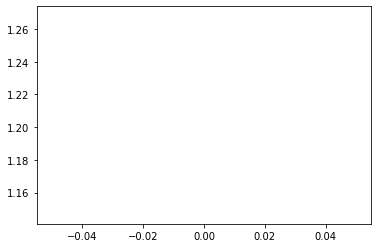

15


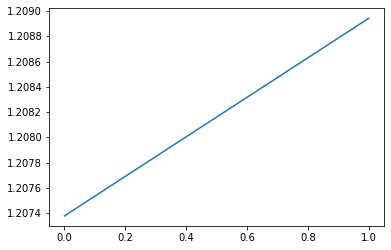

20


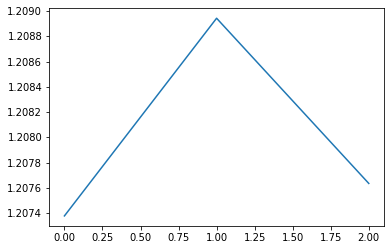

25


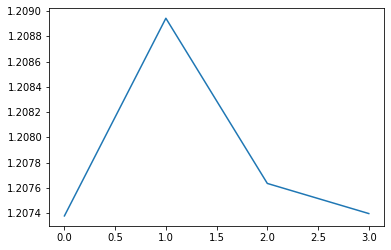

30


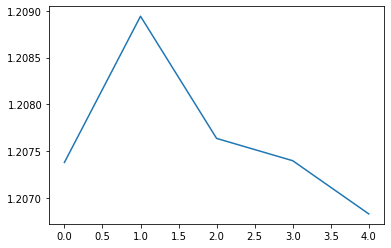

35


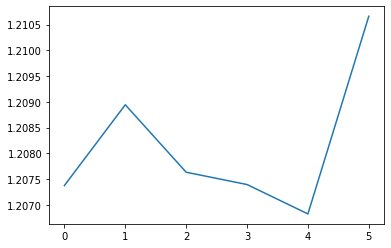

40


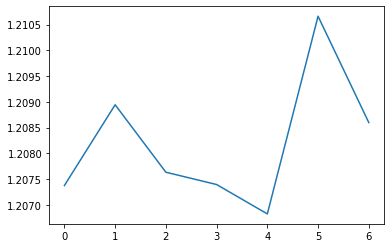

45


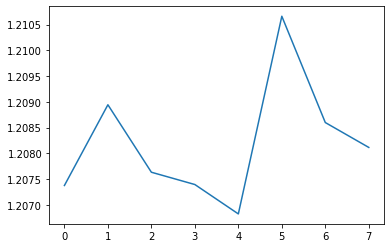

50


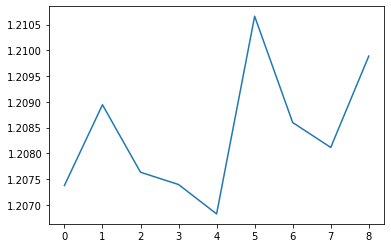

55


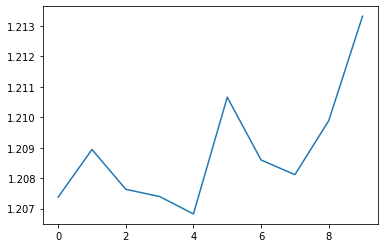

60


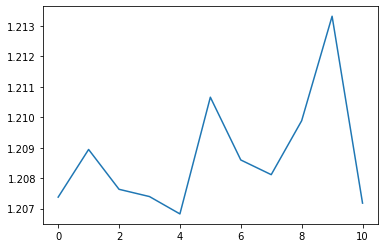

65


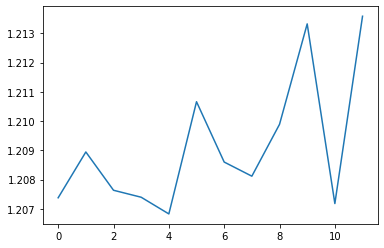

70


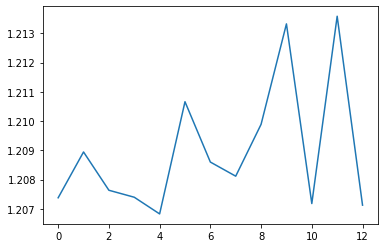

75


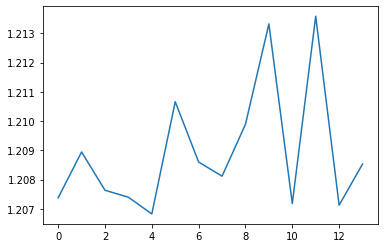

80


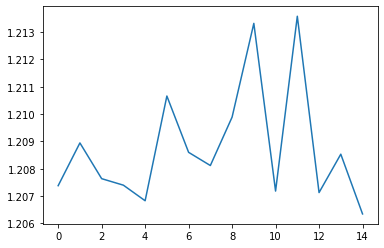

85


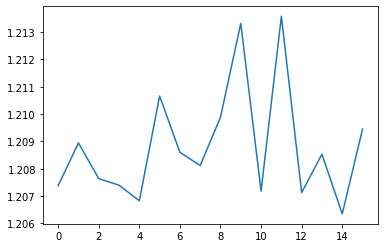

90


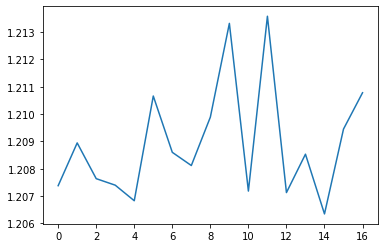

95


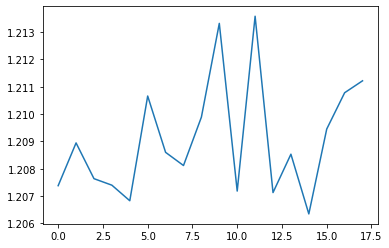

100


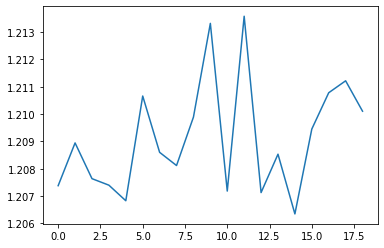

105


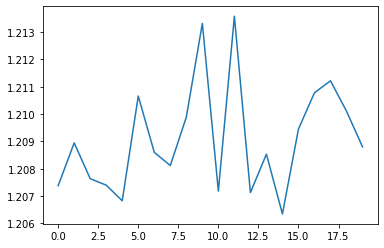

110


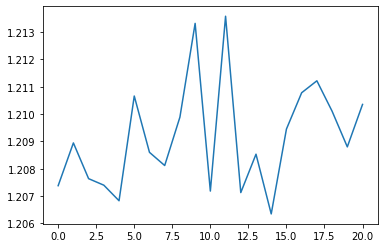

115


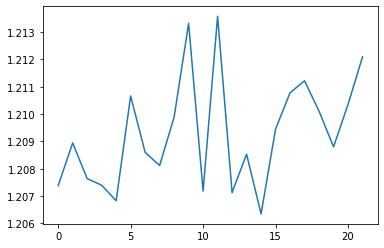

120


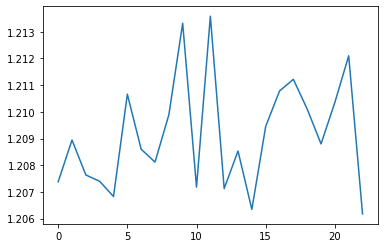

125


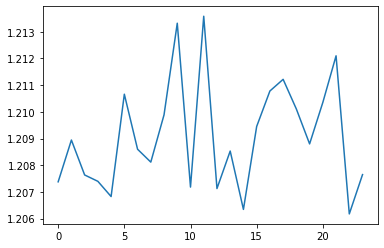

130


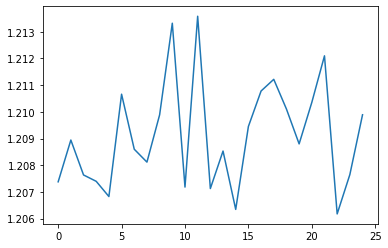

135


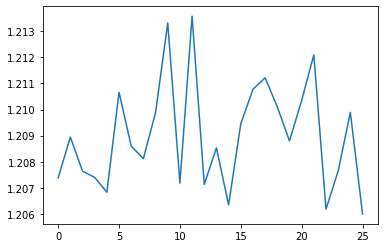

140


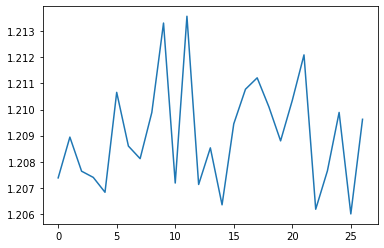

145


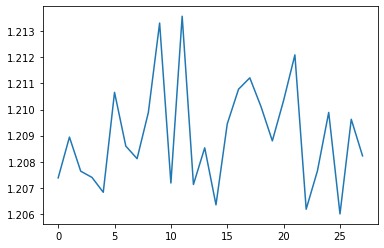

150


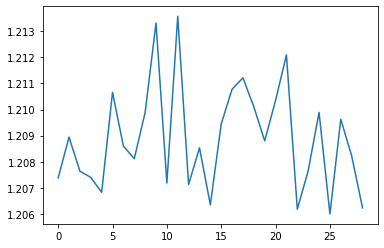

155


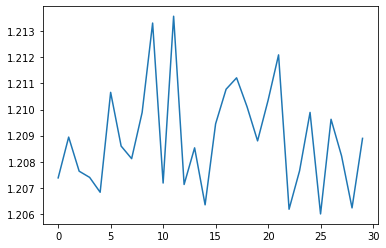

160


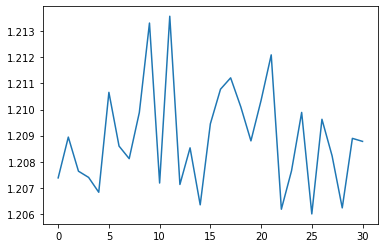

165


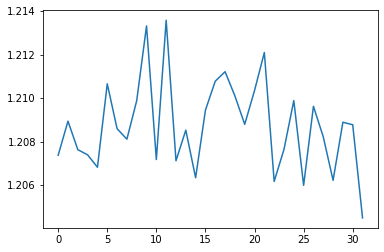

170


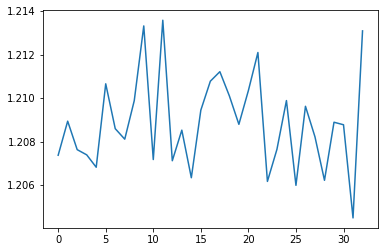

175


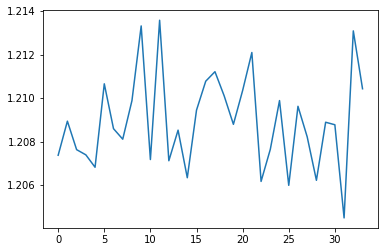

180


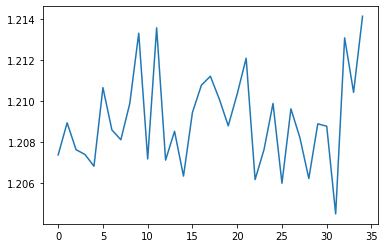

185


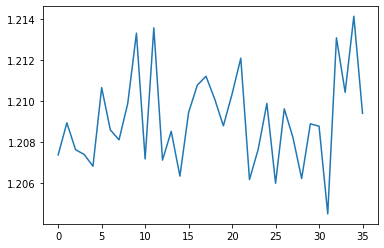

190


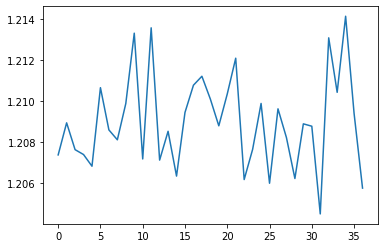

195


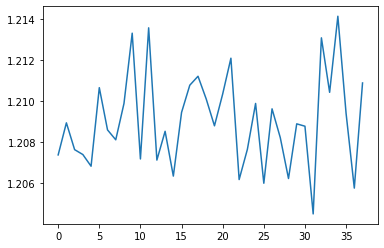

200


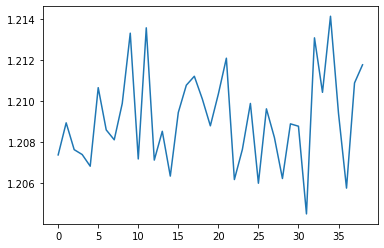

205


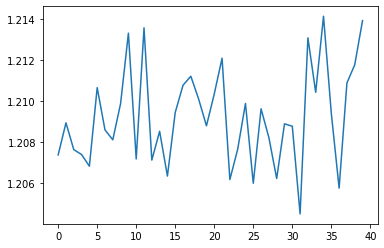

210


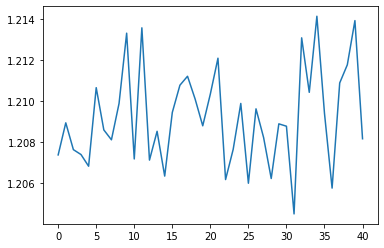

215


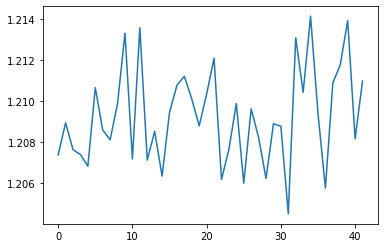

220


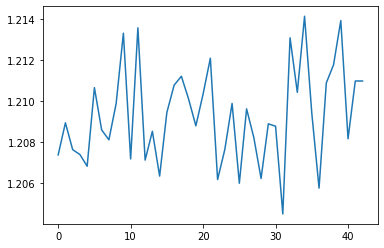

225


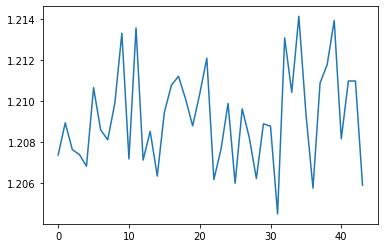

230


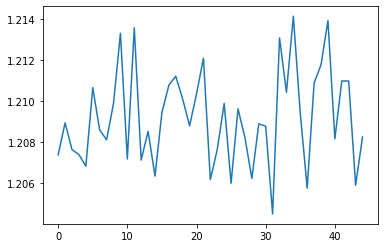

235


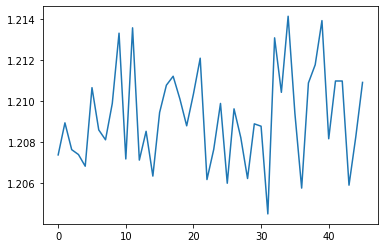

240


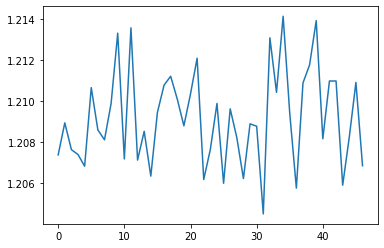

245


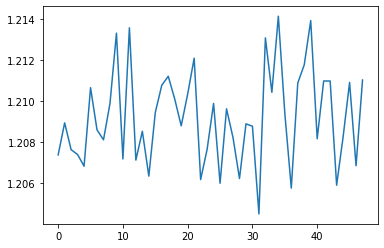

250


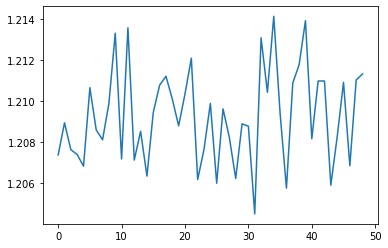

255


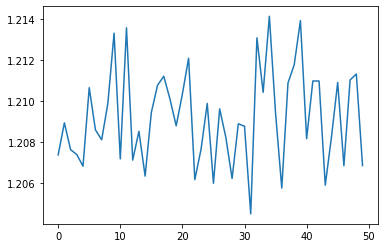

260


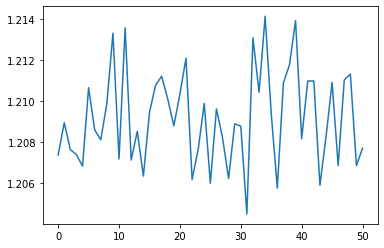

265


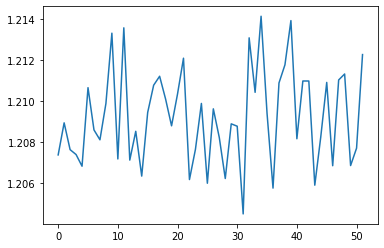

270


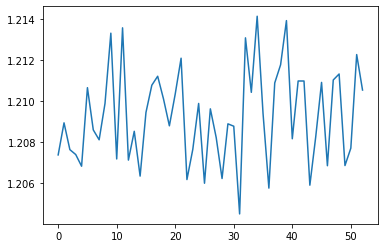

275


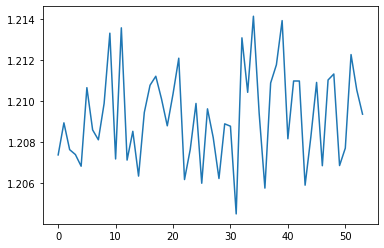

280


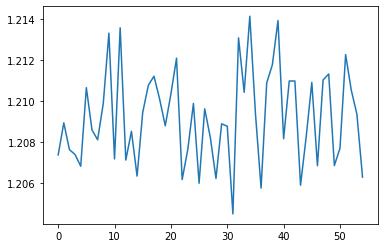

285


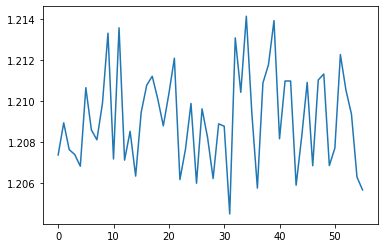

290


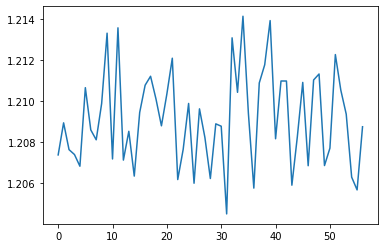

295


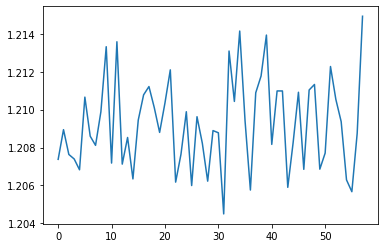

300


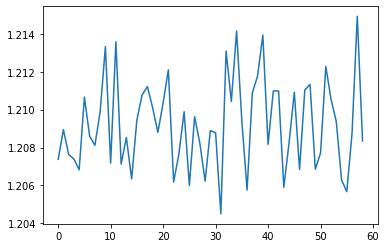

305


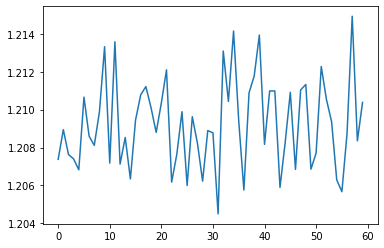

310


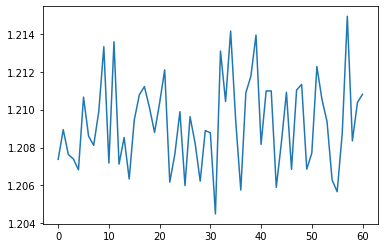

315


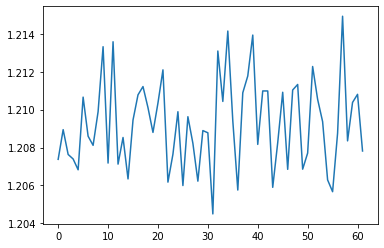

320


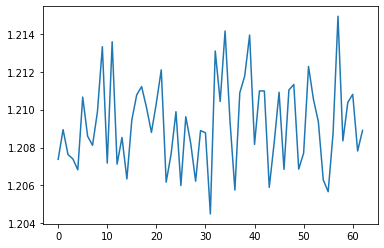

325


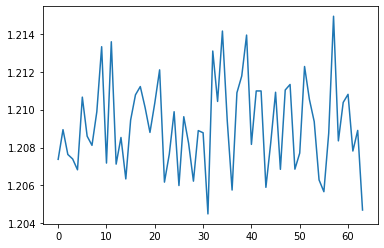

330


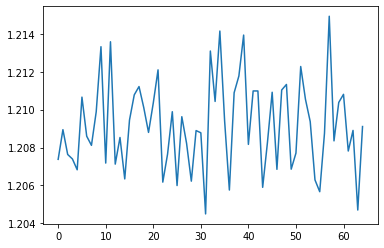

335


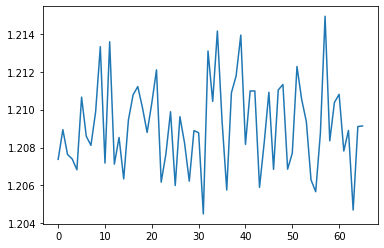

340


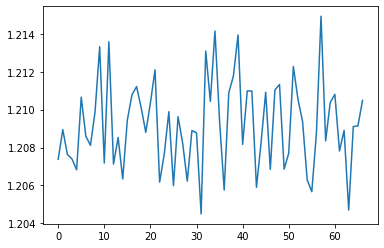

345


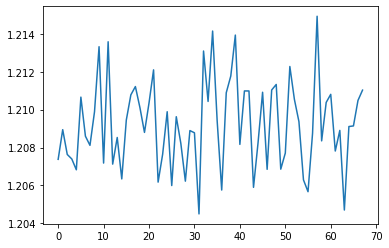

350


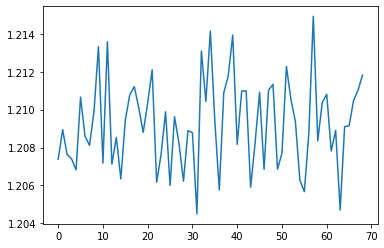

355


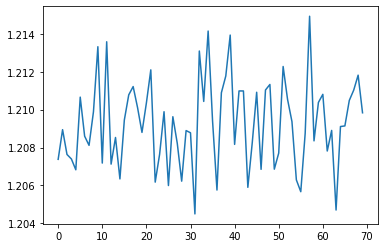

360


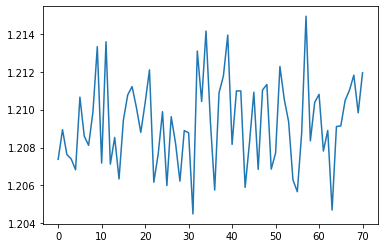

365


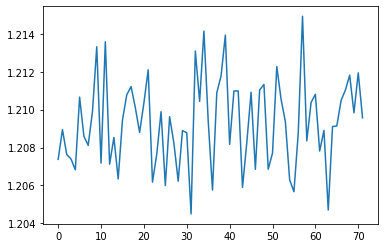

370


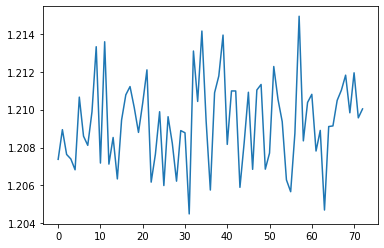

375


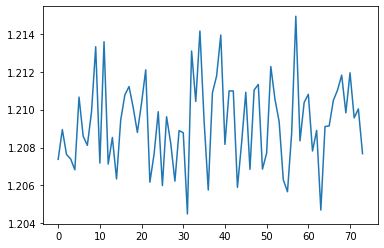

380


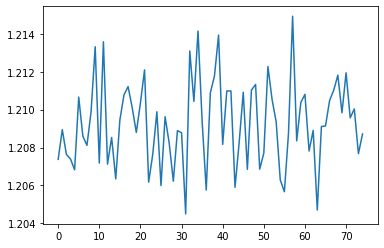

385


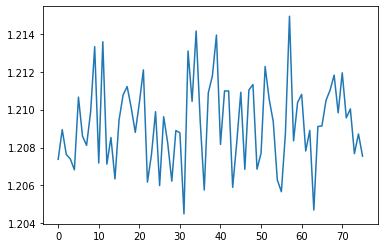

390


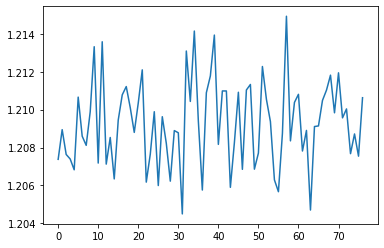

395


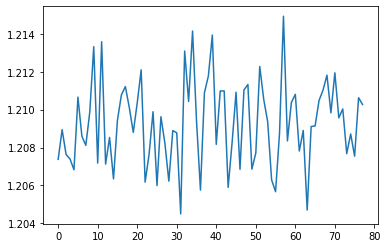

400


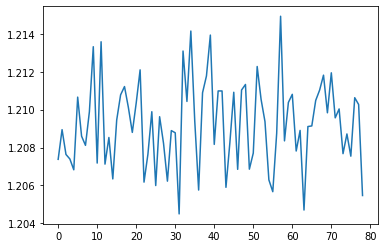

405


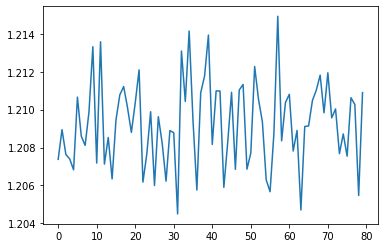

410


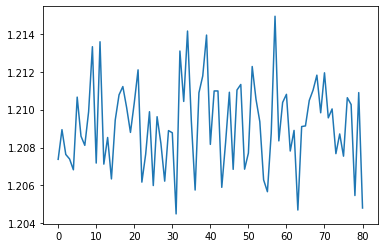

415


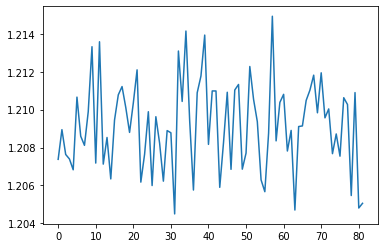

420


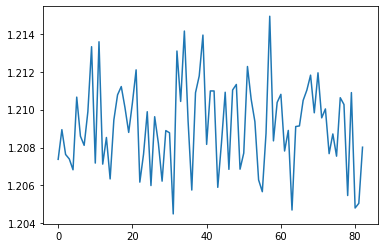

425


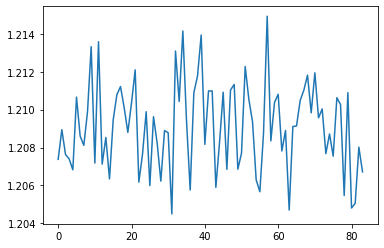

430


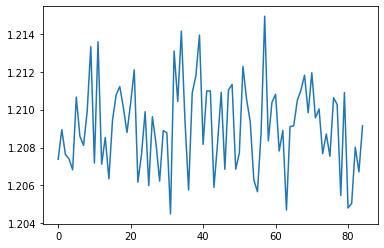

435


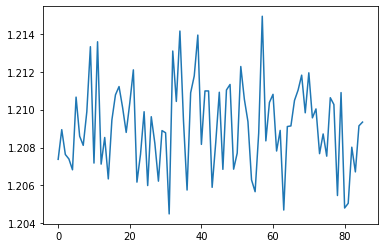

440


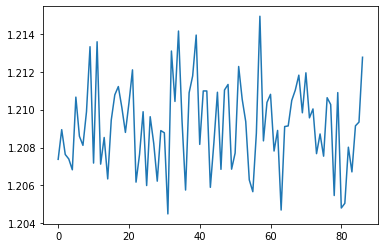

445


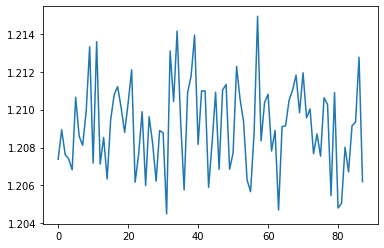

450


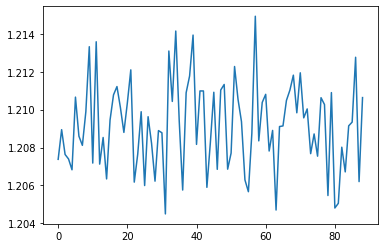

455


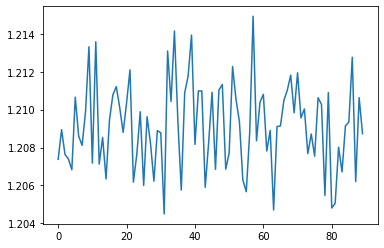

460


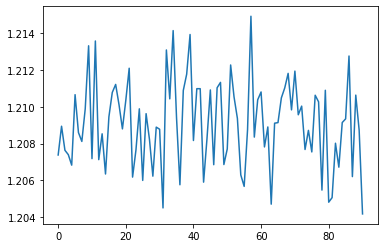

465


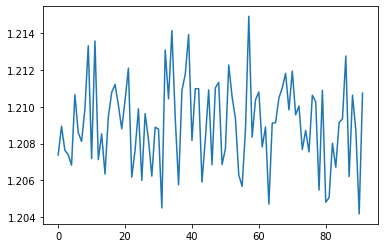

470


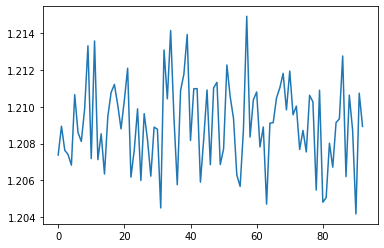

475


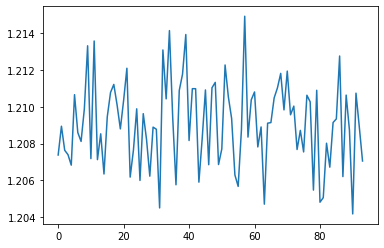

480


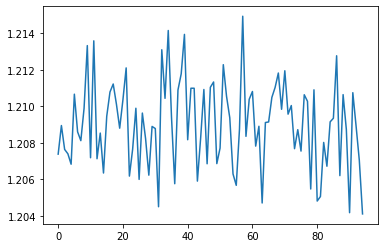

485


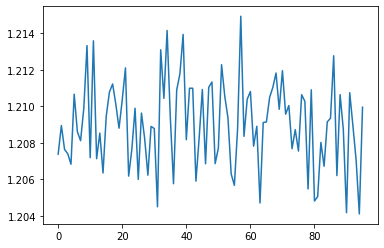

490


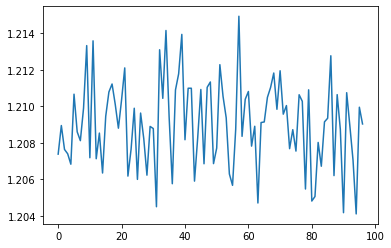

495


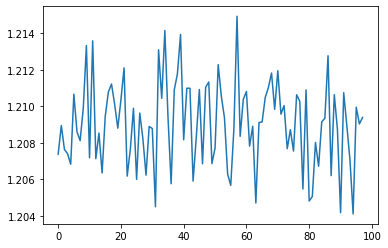

In [ ]:
preds=[]
n_vals=range(10,500,5)
for n in n_vals:
  print(n)
  preds.append(extrapol(n_vals,5))
  plt.plot(preds)
  plt.show()

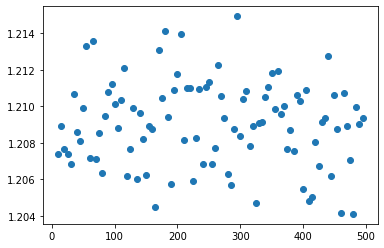

In [ ]:
plt.scatter(n_vals,preds)

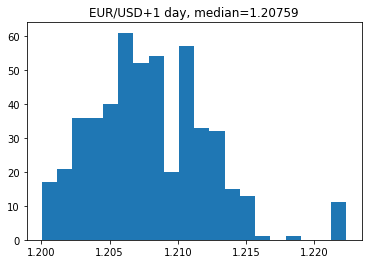

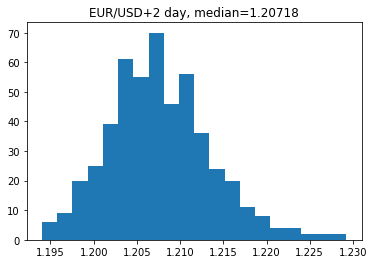

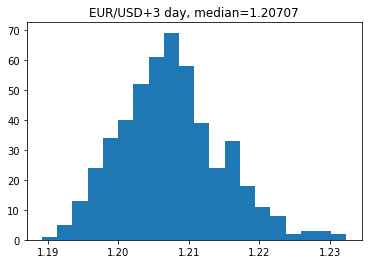

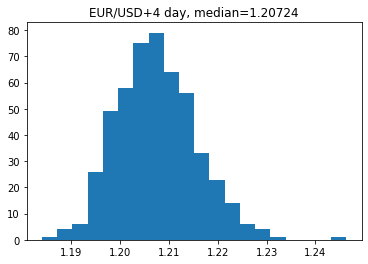

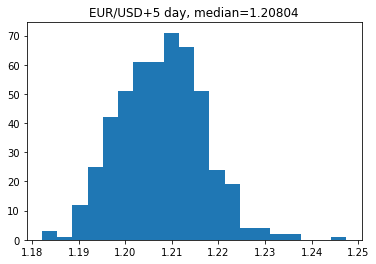

In [ ]:
for i in range(1,6+0*len(X)):
  prediction=X.iloc[i][0:n_traces]
  med=np.percentile(prediction, 50)
  plt.title(Index+'+'+str(i)+' day, median=%0.5f'%med)
  plt.hist(prediction,bins=20)
  plt.show()

In [ ]:
# Which is the N_start which gives the best accuracy on the history of the stock ? 



11

TUP united states
TSLA united states


In [ ]:


funds_list=['BE6247121302',
'BE6282431327',
'BE6282433349',
'BE6288613068',
'BE6264506526',
'BE6264508548',
'LU1860911087',
'LU1860911913',
'LU1860912721',
'LU2075804901',
'LU1860913703',
'LU1857284985',
'LU1857284985',
'LU1857284985',
'LU0465917044',
'LU0119195963'
]



In [ ]:
funds_df = investpy.get_funds(country=None)
funds_dict = investpy.get_funds_dict(country=None)

In [ ]:
def search(isin, funds):
    fund=[element for element in funds if element['isin'] == isin]
    fund=fund[0]
    return fund['name'],fund['country']

BE6247121302  found
BE6282431327  not found
BE6282433349  not found
BE6288613068  not found
BE6264506526  not found
BE6264508548  not found
LU1860911087  not found
LU1860911913  not found
LU1860912721  not found
LU2075804901  not found
LU1860913703  not found
LU1857284985  not found
LU1857284985  not found
LU1857284985  not found
LU0465917044  found
LU0119195963  found


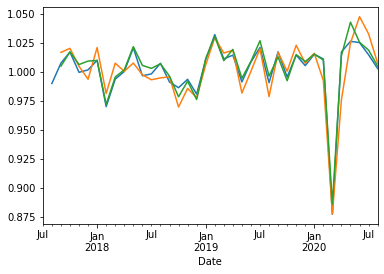

In [ ]:
fonds=[]
for isin in funds_list:
  try:
    fund_name,fund_country=search(isin,funds_dict)
    df = investpy.get_fund_historical_data(fund=fund_name, country=fund_country, from_date='01/01/2000', to_date='09/08/2020')
    # Resample by week.
    df=df.resample('M').mean()
    # Calculate the ratio 
    df['Variation']=df['Close']/(df['Close'].shift(1))
    mean_=df['Variation'].mean()
    std_=df['Variation'].std()
    fonds.append([isin,mean_,std_])
    print(isin,' found')
    df.Variation.plot()
  except:
    print(isin,' not found')
fonds=pd.DataFrame(fonds,columns=['isin','mean','std'])

In [ ]:
fonds

,isin,mean,std
0,BE6247121302,1.001865,0.025060
1,LU0465917044,1.001198,0.027710
2,LU0119195963,1.003983,0.024979


In [ ]:
# BE6247121302 ING CP CFB C
#   0P0000XZ4E Historical Data.csv
#   Mean return:  1.0266246831647217
#   Return Deviation 0.05830390458402494
# LU0119195963 NN L Pat Bal PC
#   0P00000BFP Historische Data.csv
#   Mean return:  1.0386802046259886
#   Return Deviation 0.05287636012575688

In [ ]:
def generate_interest(interest,variation, month):
  x=np.random.normal(interest, variation,month)
  return np.cumprod(x)

In [ ]:
Cash=10000
interet=fonds['mean']
variation_interet_par_mois=fonds['std']

In [ ]:
# What is best combination of portfolio which will minimize risk and maximize profit
experiments=1000
a=np.random.random(experiments)
b=np.random.random(experiments)
c=np.random.random(experiments)
d=a+b+c
a=a/d*Cash*0.97 #3% de frais d'entrée...
b=b/d*Cash*0.97 #3% de frais d'entrée...
c=c/d*Cash*0.97 #3% de frais d'entrée...

In [ ]:
evaluation_period

240

In [ ]:
N=experiments
evaluation_period=120*2
# if sampling is W, then evaluation_period=10*52=520
# is samplinf is M, then evaluation_period=10*12=120
# if sampling is 2W, then evaluation_period=10*52/2=260
z=[]
for C1,C2,C3 in zip(a,b,c):
  perc=[]
  for j in range(0,N):
    trace_a=np.multiply(C1,generate_interest(interet[0],variation_interet_par_mois[0],evaluation_period))
    trace_b=np.multiply(C2,generate_interest(interet[1],variation_interet_par_mois[1],evaluation_period))
    trace_c=np.multiply(C3,generate_interest(interet[2],variation_interet_par_mois[2],evaluation_period))
    total=trace_a+trace_b+trace_c
    plt.plot(total, color='blue',alpha=0.01)
    perc.append(total[-1])
  z.append([C1,C2,C3,np.percentile(perc,50),np.percentile(perc,10),np.percentile(perc,90)])
plt.show()

In [ ]:
# Which is a and b which gives the highest min value for confidence interval?
df=pd.DataFrame(z,columns=['a','b','c','median','low','high'])

In [ ]:
plt.scatter(df['a'],df['median'],color="red",alpha=0.5)
plt.fill_between(df['a'],df['low'],df['high'],color="blue",alpha=0.1)

In [ ]:
px.scatter(df,x='low',y='high',color="high",hover_data=["a", "b","c"])

In [ ]:
df['sum all']=(df['median']+df['low']+df['high'])/3
#df['sum all2']=(df['median']**2+df['low']**2+df['high']**2)
best=np.argmax(df['sum all'])
print(df.iloc[best])


In [ ]:
median=df.iloc[best][['high','median','low']]
frais=median*0.0175*10 # frais de gestion de 1.75% par an
inflation=1.02**10 #2% inflation par an 


In [ ]:
benef=(median-Cash/inflation-frais)*0.7 # Retirer 30% de frais sur la plus value
print("Benef=")
print(benef)

In [ ]:
print(benef/Cash)

In [ ]:
px.scatter_3d(df,x='low',y='median',z="high",color="a",hover_data=["a", "b","c","sum all"])